# NYC YELLOW TAXI AND LIMOUSINE DATA ANALYSIS

In [1]:
try:
    print("Spark is already running: ", spark, ".\nIf you have problems, you need to restart the kernel")
except:
    import findspark
    findspark.init()
    from pyspark.sql import SparkSession
    spark = SparkSession.builder.getOrCreate()

In [2]:
from pyspark.sql import functions as fn
# Functionality for computing features
from pyspark.ml import feature
# Functionality for regression
from pyspark.ml import regression
# Funcionality for classification
from pyspark.ml import classification
# Object for creating sequences of transformations
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
#from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
from dateutil import parser
import pandas as pd
import numpy as np 

In [4]:
# Reading the file directly into the server
!wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv

/bin/sh: wget: command not found


In [88]:
# Reading the dataframe from the server using pandas
taxi_df = pd.read_csv("yellow_tripdata_2016-01.csv")

In [89]:
taxi_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

In [90]:
taxi_df=taxi_df.drop(['VendorID','RatecodeID','store_and_fwd_flag','passenger_count','extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'payment_type'],axis=1)

In [91]:
taxi_df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount
0,2016-01-01 00:00:00,2016-01-01 00:00:00,1.10,-73.990372,40.734695,-73.981842,40.732407,7.5
1,2016-01-01 00:00:00,2016-01-01 00:00:00,4.90,-73.980782,40.729912,-73.944473,40.716679,18.0
2,2016-01-01 00:00:00,2016-01-01 00:00:00,10.54,-73.984550,40.679565,-73.950272,40.788925,33.0
3,2016-01-01 00:00:00,2016-01-01 00:00:00,4.75,-73.993469,40.718990,-73.962242,40.657333,16.5
4,2016-01-01 00:00:00,2016-01-01 00:00:00,1.76,-73.960625,40.781330,-73.977264,40.758514,8.0


In [92]:
taxi_df['Ptime'] = pd.to_datetime(taxi_df['tpep_pickup_datetime'])

In [93]:
taxi_df['Dtime'] = pd.to_datetime(taxi_df['tpep_dropoff_datetime'])

In [94]:
taxi_df['TripDuration']=(taxi_df['Dtime']-taxi_df['Ptime'])

In [95]:
taxi_df['TripDuration']=round((taxi_df[:len(taxi_df)]['TripDuration'] / np.timedelta64(1, 'm')))

In [ ]:
taxi_df['Phour']=taxi_df.Ptime.apply(lambda x: x.hour)

In [97]:
taxi_df['Day_of_WeekP'] = taxi_df['Ptime'].dt.weekday_name

In [98]:
taxi_df.head(5)

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,Ptime,Dtime,TripDuration,Phour,Day_of_WeekP
0,2016-01-01 00:00:00,2016-01-01 00:00:00,1.10,-73.990372,40.734695,-73.981842,40.732407,7.5,2016-01-01,2016-01-01,0.0,0,Friday
1,2016-01-01 00:00:00,2016-01-01 00:00:00,4.90,-73.980782,40.729912,-73.944473,40.716679,18.0,2016-01-01,2016-01-01,0.0,0,Friday
2,2016-01-01 00:00:00,2016-01-01 00:00:00,10.54,-73.984550,40.679565,-73.950272,40.788925,33.0,2016-01-01,2016-01-01,0.0,0,Friday
3,2016-01-01 00:00:00,2016-01-01 00:00:00,4.75,-73.993469,40.718990,-73.962242,40.657333,16.5,2016-01-01,2016-01-01,0.0,0,Friday
4,2016-01-01 00:00:00,2016-01-01 00:00:00,1.76,-73.960625,40.781330,-73.977264,40.758514,8.0,2016-01-01,2016-01-01,0.0,0,Friday


In [101]:
taxi_fnl=taxi_df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime','Ptime','Dtime'],axis=1)

In [102]:
taxi_fnl.head(5)

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,TripDuration,Phour,Day_of_WeekP
0,1.10,-73.990372,40.734695,-73.981842,40.732407,7.5,0.0,0,Friday
1,4.90,-73.980782,40.729912,-73.944473,40.716679,18.0,0.0,0,Friday
2,10.54,-73.984550,40.679565,-73.950272,40.788925,33.0,0.0,0,Friday
3,4.75,-73.993469,40.718990,-73.962242,40.657333,16.5,0.0,0,Friday
4,1.76,-73.960625,40.781330,-73.977264,40.758514,8.0,0.0,0,Friday


# Finding correlation

In [103]:
taxi_fnl.describe()

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,TripDuration,Phour
count,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07,1.090686e+07
mean,4.648197e+00,-7.281869e+01,4.011494e+01,-7.288659e+01,4.015315e+01,1.248693e+01,1.526830e+01,1.354638e+01
std,2.981095e+03,9.168964e+00,5.051022e+00,8.900841e+00,4.903456e+00,3.556400e+01,8.690761e+01,6.391860e+00
min,0.000000e+00,-1.219343e+02,0.000000e+00,-1.219335e+02,0.000000e+00,-9.576000e+02,-4.400000e+01,0.000000e+00
25%,1.000000e+00,-7.399151e+01,4.073630e+01,-7.399107e+01,4.073481e+01,6.500000e+00,6.000000e+00,9.000000e+00
50%,1.670000e+00,-7.398138e+01,4.075369e+01,-7.397942e+01,4.075413e+01,9.000000e+00,1.000000e+01,1.400000e+01
75%,3.080000e+00,-7.396610e+01,4.076808e+01,-7.396196e+01,4.076962e+01,1.400000e+01,1.700000e+01,1.900000e+01
max,8.000010e+06,0.000000e+00,6.090876e+01,0.000000e+00,6.090876e+01,1.112709e+05,1.199130e+05,2.300000e+01


In [104]:
taxi_fnl.corr()

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,TripDuration,Phour
trip_distance,1.000000,-0.000083,0.000083,-0.000085,0.000091,0.000392,0.000152,-0.000020
pickup_longitude,-0.000083,1.000000,-0.999934,0.872841,-0.872787,0.004237,-0.001873,-0.001506
pickup_latitude,0.000083,-0.999934,1.000000,-0.872798,0.872829,-0.004132,0.001876,0.001683
dropoff_longitude,-0.000085,0.872841,-0.872798,1.000000,-0.999907,0.003048,-0.002642,-0.000434
dropoff_latitude,0.000091,-0.872787,0.872829,-0.999907,1.000000,-0.003026,0.002601,0.000371
fare_amount,0.000392,0.004237,-0.004132,0.003048,-0.003026,1.000000,0.030443,-0.003512
TripDuration,0.000152,-0.001873,0.001876,-0.002642,0.002601,0.030443,1.000000,-0.000354
Phour,-0.000020,-0.001506,0.001683,-0.000434,0.000371,-0.003512,-0.000354,1.000000


In [105]:
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
temp = taxi_fnl[(taxi_fnl['trip_distance'] > 1) & (taxi_fnl['trip_distance'] < 5.4) & (taxi_fnl['TripDuration'] < 28) & (taxi_fnl['fare_amount'] < 20.5)]
temp = temp[(temp['TripDuration'] > 0.0000) & (temp['fare_amount'] > 1)]
temp = temp[(temp['pickup_longitude'] != 0.0000) & (temp['dropoff_longitude'] != 0.0000)]
len(temp)
temp.boxplot(return_type='axes');

In [ ]:
len(temp)

In [110]:
temp.boxplot(return_type='axes');

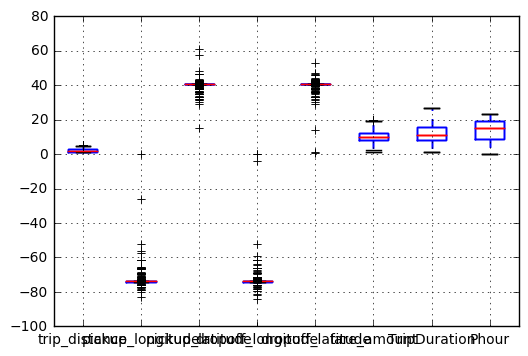

In [111]:
plt.show()

In [107]:
taxi_temp = temp.sample(n=50000)

In [108]:
taxi_temp.corr()

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,TripDuration,Phour
trip_distance,1.000000,0.008148,-0.051393,0.158594,-0.072604,0.866762,0.592711,-0.036278
pickup_longitude,0.008148,1.000000,0.703561,0.450628,0.205359,-0.012506,-0.038399,-0.019567
pickup_latitude,-0.051393,0.703561,1.000000,0.113282,0.303342,-0.039712,-0.022723,0.012685
dropoff_longitude,0.158594,0.450628,0.113282,1.000000,0.417711,0.085108,-0.006558,-0.030446
dropoff_latitude,-0.072604,0.205359,0.303342,0.417711,1.000000,-0.084384,-0.075452,0.029289
fare_amount,0.866762,-0.012506,-0.039712,0.085108,-0.084384,1.000000,0.902333,0.006431
TripDuration,0.592711,-0.038399,-0.022723,-0.006558,-0.075452,0.902333,1.000000,0.055581
Phour,-0.036278,-0.019567,0.012685,-0.030446,0.029289,0.006431,0.055581,1.000000


In [112]:
plt.scatter(y=taxi_temp['TripDuration'],x=taxi_temp['fare_amount'])

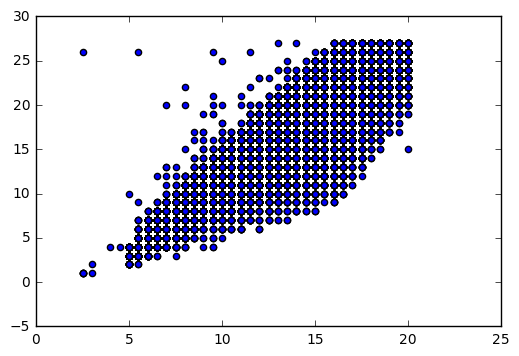

In [113]:
plt.show()

In [114]:
plt.scatter(y=taxi_temp['TripDuration'],x=taxi_temp['trip_distance'])

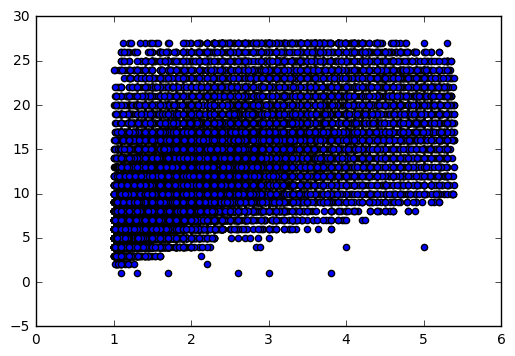

In [115]:
plt.show()

# Reverse geocoding to get zip codes

# Pickup locations

In [18]:
ziplistPickup = []
ziplistDropoff = []
countP = 0

In [19]:
import geocoder
import time

In [ ]:
for index, row in taxi_df.iterrows():    
        location1 = geocoder.bing([taxi_df['pickup_latitude'][index], taxi_df['pickup_longitude'][index]], method='reverse', key='AttqTtXAM_SEeSZpjmY7Waz5AUgsmwjldiQyl_9oBTVBXb11L7yhqh94tMr7cdG8')
        location2 = geocoder.bing([taxi_df['dropoff_latitude'][index], taxi_df['dropoff_longitude'][index]], method='reverse', key='AttqTtXAM_SEeSZpjmY7Waz5AUgsmwjldiQyl_9oBTVBXb11L7yhqh94tMr7cdG8')
        if (location1.address != None) & (location2.address != None):
            ziplistPickup.append(location1.postal)
            ziplistDropoff.append(location2.postal)
        else:
            ziplistPickup.append("LOCATION NOT FOUND")
            ziplistDropoff.append("LOCATION NOT FOUND")
        countP=countP+1
        print(countP)

In [ ]:
print(len(ziplistPickup))

In [ ]:
df = pd.DataFrame(ziplistPickup)

In [ ]:
df.columns=['Pickup_Zipcode']

# Dropoff locations

In [ ]:
ziplistDropoff = []
countD = 0

In [ ]:
for index, row in taxi_df.iterrows():    
    if taxi_df['dropoff_longitude'][index] == 0 and taxi_df['dropoff_latitude'][index] == 0:
        ziplistDropoff.append("INVALID LOCATION")
    elif taxi_df['dropoff_longitude'][index] == 0 or taxi_df['dropoff_latitude'][index] == 0:
        ziplistDropoff.append("INVALID LOCATION")        
    else:
        location = geocoder.bing([taxi_df['dropoff_longitude'][index], taxi_df['dropoff_latitude'][index]], method='reverse', key='AttqTtXAM_SEeSZpjmY7Waz5AUgsmwjldiQyl_9oBTVBXb11L7yhqh94tMr7cdG8')
        if location.address != None:
            ziplistDropoff.append(location.postal)
        else:
            ziplistDropoff.append("LOCATION NOT FOUND")
        countD=countD+1
        print(countD)

In [ ]:
print(len(ziplistDropoff))

In [ ]:
df1 = pd.DataFrame(ziplistDropoff)

In [ ]:
df1.columns=['Dropoff_Zipcode']

# Loading into spark

In [10]:
taxiDf = spark.createDataFrame(taxi_df)

In [11]:
taxiDf.show()

+-------------+------------------+------------------+------------------+------------------+-----------+------------+------------+-----+
|trip_distance|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|fare_amount|TripDuration|Day_of_WeekP|Phour|
+-------------+------------------+------------------+------------------+------------------+-----------+------------+------------+-----+
|          2.5|   -73.99072265625|   40.749267578125|-73.96504974365234| 40.75496292114258|        9.5|         9.0|      Friday|    2|
|          1.3| -73.9751968383789|  40.7823600769043|-73.96562194824219| 40.79207992553711|        6.5|         5.0|      Sunday|   19|
|         1.47|-74.00397491455078| 40.72573852539063|-73.99896240234375| 40.74453353881836|        6.5|         6.0|      Sunday|   14|
|          1.4|-73.97034454345702|40.752235412597656|-73.97855377197266| 40.73601531982422|        6.5|         5.0|   Wednesday|   21|
|          1.2|-74.01358032226562|40.71283340454

In [ ]:
for i in taxiDf.columns:
    print("Correlation between Trip Duration and ",i," is ",taxiDf.stat.corr('TripDuration',i))

# Indexing Day of week and Pickup hour

In [15]:
from pyspark.ml.feature import StringIndexer
stringIndexer = StringIndexer(inputCol="Day_of_WeekP", outputCol="Day_indexed",)
si_model = stringIndexer.fit(taxiDf)
td = si_model.transform(taxiDf)
td.cache()
td.show(20)

+-------------+------------------+------------------+------------------+------------------+-----------+------------+------------+-----+-----------+
|trip_distance|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|fare_amount|TripDuration|Day_of_WeekP|Phour|Day_indexed|
+-------------+------------------+------------------+------------------+------------------+-----------+------------+------------+-----+-----------+
|          2.5|   -73.99072265625|   40.749267578125|-73.96504974365234| 40.75496292114258|        9.5|         9.0|      Friday|    2|        0.0|
|          1.3| -73.9751968383789|  40.7823600769043|-73.96562194824219| 40.79207992553711|        6.5|         5.0|      Sunday|   19|        2.0|
|         1.47|-74.00397491455078| 40.72573852539063|-73.99896240234375| 40.74453353881836|        6.5|         6.0|      Sunday|   14|        2.0|
|          1.4|-73.97034454345702|40.752235412597656|-73.97855377197266| 40.73601531982422|        6.5|         

In [16]:
from pyspark.ml.feature import StringIndexer
stringIndexer = StringIndexer(inputCol="Phour", outputCol="Phour_indexed")
si_model = stringIndexer.fit(td)
td1 = si_model.transform(td)
td1.cache()
td1.show(20)

+-------------+------------------+------------------+------------------+------------------+-----------+------------+------------+-----+-----------+-------------+
|trip_distance|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|fare_amount|TripDuration|Day_of_WeekP|Phour|Day_indexed|Phour_indexed|
+-------------+------------------+------------------+------------------+------------------+-----------+------------+------------+-----+-----------+-------------+
|          2.5|   -73.99072265625|   40.749267578125|-73.96504974365234| 40.75496292114258|        9.5|         9.0|      Friday|    2|        0.0|         19.0|
|          1.3| -73.9751968383789|  40.7823600769043|-73.96562194824219| 40.79207992553711|        6.5|         5.0|      Sunday|   19|        2.0|          0.0|
|         1.47|-74.00397491455078| 40.72573852539063|-73.99896240234375| 40.74453353881836|        6.5|         6.0|      Sunday|   14|        2.0|          7.0|
|          1.4|-73.970344543

In [24]:
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml import feature
from pyspark.ml import regression

# Splitting data into train, validate and test

In [32]:
trainingData, testData, validation = td1.randomSplit([0.6, 0.3, 0.1])

In [33]:
print(trainingData.count())
print(testData.count())
print(validation.count())

30164
14845
4991


In [69]:
va1 = feature.VectorAssembler(inputCols=['trip_distance','fare_amount','Phour_indexed','Day_indexed'], outputCol='features')
va2 = feature.VectorAssembler(inputCols=['trip_distance','Phour_indexed','Day_indexed'], outputCol='features')
va3 = feature.VectorAssembler(inputCols=['Phour_indexed','Day_indexed'], outputCol='features')

# Linear Regression

In [70]:
lr1 = regression.LinearRegression(featuresCol='features', labelCol='TripDuration')

## LR - Model 1

In [71]:
pipeline1 = Pipeline(stages=[va1, lr1])

In [72]:
linear_model1 = pipeline1.fit(trainingData)
linear_model1.transform(trainingData).select('TripDuration', 'prediction')
linear_model1.transform(trainingData).\
    select(fn.avg((fn.col('prediction') - fn.col('TripDuration'))**2).alias('MSE for LR 1')).\
    show()

+-----------------+
|     MSE for LR 1|
+-----------------+
|1.056190821661912|
+-----------------+



## LR - Model 2

In [73]:
pipeline2 = Pipeline(stages=[va2, lr1])

In [74]:
linear_model2 = pipeline2.fit(trainingData)
linear_model2.transform(trainingData).select('TripDuration', 'prediction')
linear_model2.transform(trainingData).\
    select(fn.avg((fn.col('prediction') - fn.col('TripDuration'))**2).alias('MSE for LR 2')).\
    show()

+------------------+
|      MSE for LR 2|
+------------------+
|16.785086246407005|
+------------------+



## LR - Model 3

In [75]:
pipeline3 = Pipeline(stages=[va3, lr1])

In [76]:
linear_model3 = pipeline3.fit(trainingData)
linear_model3.transform(trainingData).select('TripDuration', 'prediction')
linear_model3.transform(trainingData).\
    select(fn.avg((fn.col('prediction') - fn.col('TripDuration'))**2).alias('MSE for LR 3')).\
    show()

+-----------------+
|     MSE for LR 3|
+-----------------+
|26.17855809765752|
+-----------------+



# Random Forest Regression

In [77]:
rf = RandomForestRegressor(labelCol="TripDuration",featuresCol="features")

## RF - Model 1

In [78]:
pipeline4 = Pipeline(stages=[va1, rf])

In [79]:
RF_model1 = pipeline4.fit(trainingData)
RF_model1.transform(trainingData).select('TripDuration', 'prediction')
RF_model1.transform(trainingData).\
    select(fn.avg((fn.col('prediction') - fn.col('TripDuration'))**2).alias('MSE for RF 1')).\
    show()

+-----------------+
|     MSE for RF 1|
+-----------------+
|4.381486795488381|
+-----------------+



## RF - Model 2

In [80]:
pipeline5 = Pipeline(stages=[va2, rf])

In [81]:
RF_model2 = pipeline5.fit(trainingData)
RF_model2.transform(trainingData).select('TripDuration', 'prediction')
RF_model2.transform(trainingData).\
    select(fn.avg((fn.col('prediction') - fn.col('TripDuration'))**2).alias('MSE for RF 2')).\
    show()

+------------------+
|      MSE for RF 2|
+------------------+
|24.400940049192513|
+------------------+



## RF - Model 3

In [82]:
pipeline6 = Pipeline(stages=[va3, rf])

In [83]:
RF_model3 = pipeline6.fit(trainingData)
RF_model3.transform(trainingData).select('TripDuration', 'prediction')
RF_model3.transform(trainingData).\
    select(fn.avg((fn.col('prediction') - fn.col('TripDuration'))**2).alias('MSE for RF 3')).\
    show()

+------------------+
|      MSE for RF 3|
+------------------+
|25.941497749065732|
+------------------+



# Validation

In [84]:
linear_model1.transform(validation).\
    select(fn.avg((fn.col('prediction') - fn.col('TripDuration'))**2).alias('MSE validation for LR 1')).\
    show()

linear_model2.transform(validation).\
    select(fn.avg((fn.col('prediction') - fn.col('TripDuration'))**2).alias('MSE validation for LR 2')).\
    show()
    
linear_model3.transform(validation).\
    select(fn.avg((fn.col('prediction') - fn.col('TripDuration'))**2).alias('MSE validation for LR 3')).\
    show()

RF_model1.transform(validation).\
    select(fn.avg((fn.col('prediction') - fn.col('TripDuration'))**2).alias('MSE validation for RF 1')).\
    show()
    
RF_model2.transform(validation).\
    select(fn.avg((fn.col('prediction') - fn.col('TripDuration'))**2).alias('MSE validation for RF 2')).\
    show()
    
RF_model3.transform(validation).\
    select(fn.avg((fn.col('prediction') - fn.col('TripDuration'))**2).alias('MSE validation for RF 3')).\
    show()

+-----------------------+
|MSE validation for LR 1|
+-----------------------+
|     1.1954747781057566|
+-----------------------+

+-----------------------+
|MSE validation for LR 2|
+-----------------------+
|     16.518706279516582|
+-----------------------+

+-----------------------+
|MSE validation for LR 3|
+-----------------------+
|       26.1091203324706|
+-----------------------+

+-----------------------+
|MSE validation for RF 1|
+-----------------------+
|      4.511142012360113|
+-----------------------+

+-----------------------+
|MSE validation for RF 2|
+-----------------------+
|     24.646183339794867|
+-----------------------+

+-----------------------+
|MSE validation for RF 3|
+-----------------------+
|      25.67605687439053|
+-----------------------+



# Estimate of the generalization performance in MSE of the best model chosen 

In [87]:
linear_model1.transform(testData).\
    select(fn.avg((fn.col('prediction') - fn.col('TripDuration'))**2).alias('MSE')).\
    show()

+------------------+
|               MSE|
+------------------+
|1.1561986896563763|
+------------------+



In [120]:
td1.show()

+-------------+------------------+------------------+------------------+------------------+-----------+------------+------------+-----+-----------+-------------+
|trip_distance|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|fare_amount|TripDuration|Day_of_WeekP|Phour|Day_indexed|Phour_indexed|
+-------------+------------------+------------------+------------------+------------------+-----------+------------+------------+-----+-----------+-------------+
|          2.5|   -73.99072265625|   40.749267578125|-73.96504974365234| 40.75496292114258|        9.5|         9.0|      Friday|    2|        0.0|         19.0|
|          1.3| -73.9751968383789|  40.7823600769043|-73.96562194824219| 40.79207992553711|        6.5|         5.0|      Sunday|   19|        2.0|          0.0|
|         1.47|-74.00397491455078| 40.72573852539063|-73.99896240234375| 40.74453353881836|        6.5|         6.0|      Sunday|   14|        2.0|          7.0|
|          1.4|-73.970344543

In [154]:
new_trip = spark.createDataFrame([
    [8.2, 0, 0]], ['trip_distance','Phour_indexed','Day_indexed'])

In [155]:
linear_model2.transform(new_trip).collect()

[Row(trip_distance=8.2, Phour_indexed=0, Day_indexed=0, features=DenseVector([8.2, 0.0, 0.0]), prediction=31.41591349433579)]